# 1. Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm as lgb
import catboost as cb
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

# 2. Load DataSet

In [2]:
%%time
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

CPU times: user 16.6 s, sys: 2.78 s, total: 19.4 s
Wall time: 19.4 s


In [3]:
print(train.shape)
train.head()

(200000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
print(test.shape)
test.head()

(200000, 201)


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


train has 20000 samples and 202 features, and test has 20000samples and 201 features.

# 3. Check DataSet

## 3-1. DataSet information

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


All of feature type of train and test is float64 except target(int64) and ID_code column(objet). So there seems to be no need to classify by data type.

## 3-2. Describe DataSet

In [7]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

In [8]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,0.371335,-3.268551,14.022662,8.540872,7.532703,14.573704,9.321669,-5.70445,15.265776,12.456675,13.298428,17.230598,4.299010,3.019707,10.567479,13.666970,-3.983721,-1.129536,5.530656,5.047247,-7.687695,10.404920,-0.524830,14.762686,11.434861,3.870130,2.213288,5.875048,10.647806,0.672667,...,24.146181,5.635300,5.360975,11.026376,-2.857328,19.320760,2.962821,-4.189133,4.930356,5.633716,-0.020824,-0.805148,19.779528,-0.666240,20.264135,11.635715,-2.776134,11.864538,-0.949318,2.582604,-2.722636,10.080827,0.651432,8.768929,12.719302,-3.963045,8.978800,-10.291919,15.366094,0.755673,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,5.508661,5.961443,0.190071,4.628712,2.255257,0.411592,2.544860,6.74646,7.846983,7.989812,5.884245,8.199877,2.844023,0.527951,3.771047,0.285454,5.945853,1.524765,0.785618,2.610078,7.971581,2.156324,2.588700,4.325727,0.541040,5.170614,3.120685,2.257235,4.260820,4.078592,...,10.876184,0.217936,1.426064,5.268894,5.457937,5.039303,0.370668,7.827428,3.086443,0.365750,4.417876,5.378492,8.678024,5.987419,7.141816,2.884821,7.557001,2.626556,8.570314,2.803890,5.225554,1.369546,8.961936,4.464461,9.316889,4.724641,3.206635,11.562352,3.929227,0.976123,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,-22.672400,-25.811800,13.424500,-4.741300,0.670300,13.203400,0.314300,-28.90690,-11.324200,-12.699400,-2.634600,-9.940600,-5.164000,1.390600,-0.731300,12.749600,-24.536100,-6.040900,2.842500,-4.421500,-34.054800,1.309200,-8.209000,1.691100,9.776400,-16.923800,-10.466800,-0.885100,-5.368300,-14.083700,...,-8.925700,4.910600,0.106200,-6.093700,-21.514000,3.667300,1.813100,-37.176400,-5.405700,4.291500,-15.593200,-20.393600,-11.796600,-21.342800,-2.485400,2.951200,-29.838400,5.025300,-29.118500,-7.767400,-20.610600,5.346000,-28.092800,-5.476800,-17.011400,-22.467000,-2.303800,-47.306400,4.429100,-2.511500,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.91190

## 3-3. Missing Values

In [9]:
arr = train.isnull().sum()

result = 0
for num in arr:
    result = result + num
print(result)

0


In [10]:
arr = test.isnull().sum()

result = 0
for num in arr:
    result = result + num
print(result)

0


There are no missing values.

This data set is so intersting.
All of the feature names have same form like "var_n". Also every feature type is same float64. And there are no missing values. I think this shows the end of minimalism as dataset.

# 4. meta

In [11]:
# 할 필요 있나
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'ID_code':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the kind

    if train[f].dtypes == object:
        kind = 'nominal'
    elif train[f].dtypes == float:
        kind = 'continuous'
    elif train[f].dtypes == int:
        kind = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtypes
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'kind': kind,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'kind', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [12]:
meta

,role,kind,keep,dtype
varname,,,,
ID_code,id,nominal,True,object
target,target,ordinal,True,int64
var_0,input,continuous,True,float64
var_1,input,continuous,True,float64
var_2,input,continuous,True,float64
var_3,input,continuous,True,float64
var_4,input,continuous,True,float64
var_5,input,continuous,True,float64
var_6,input,continuous,True,float64


In [13]:
pd.DataFrame({'count' : meta.groupby(['role', 'kind'])['role'].size()}).reset_index()

,role,kind,count
0,id,nominal,1
1,input,continuous,200
2,target,ordinal,1


In [14]:
continous_fs = train.dtypes[train.dtypes == float].index.tolist()
ordinal_fs = train.dtypes[train.dtypes == int].index.tolist()
ordinal_fs.remove('target')
nominal_fs = train.dtypes[train.dtypes == object].index.tolist()
nominal_fs.remove('ID_code')
numerical_fs = continous_fs + ordinal_fs

# 5. EDA

## 5-1. Percentage & Count of target

Text(0.5, 1.0, 'Count of target')

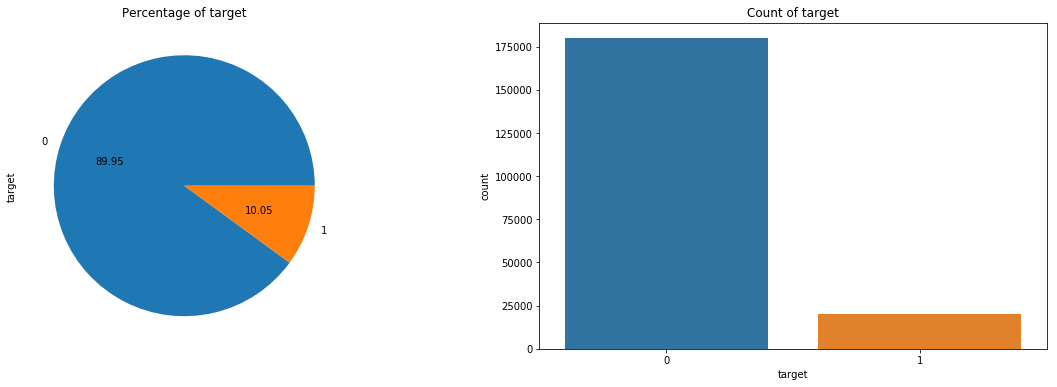

In [15]:
f,axes = plt.subplots(1,2,figsize=(20,6))
train['target'].value_counts().plot.pie(autopct='%.2f', ax=axes[0])
axes[0].set_title('Percentage of target')
sns.countplot(train['target'], ax=axes[1])
axes[1].set_title('Count of target')

# cotinous featuers EDA

## 5-2. Distribution
As we know, all of features are cotinuous. So I want to see distributions of them.

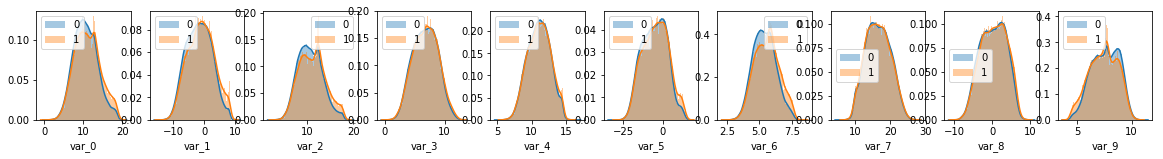

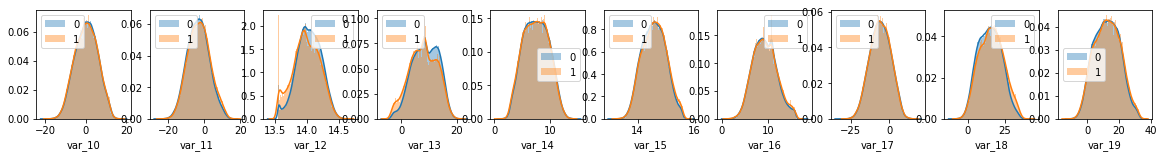

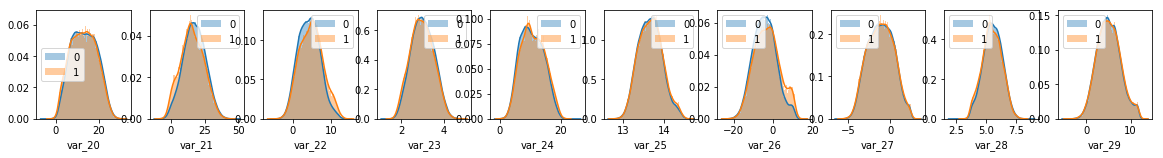

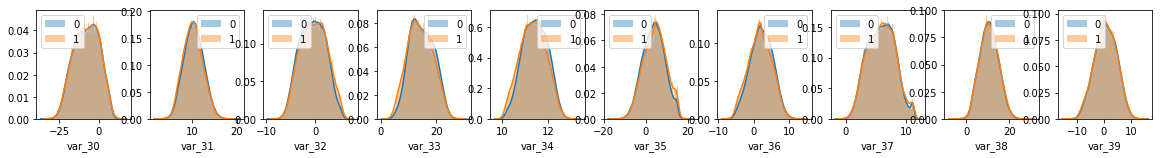

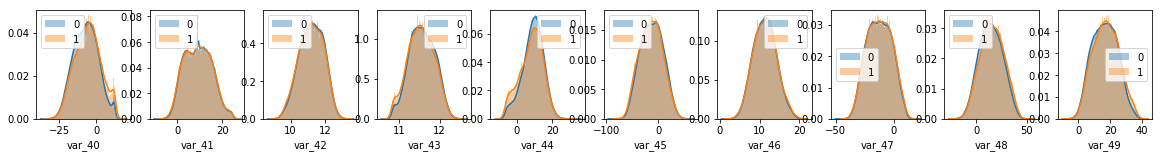

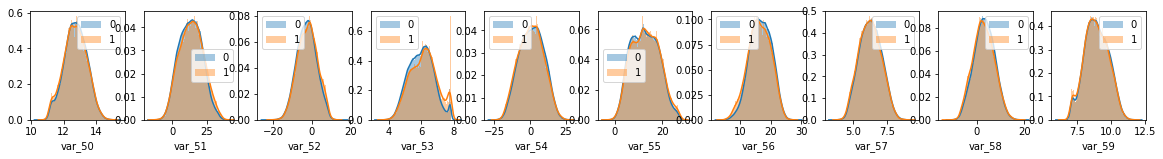

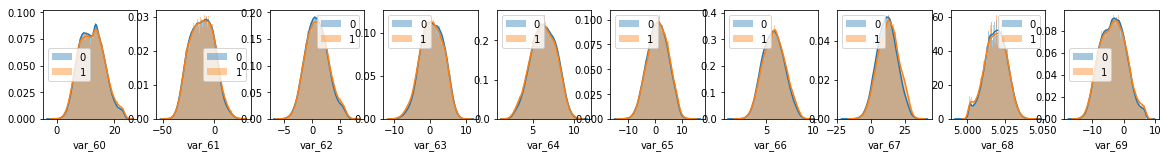

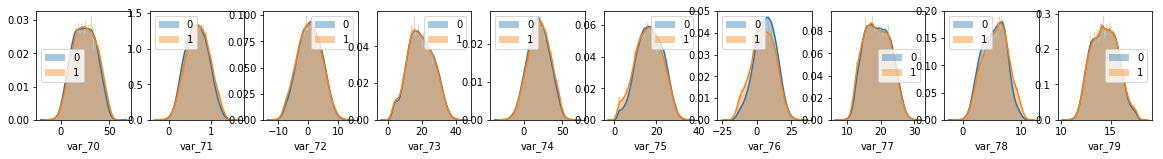

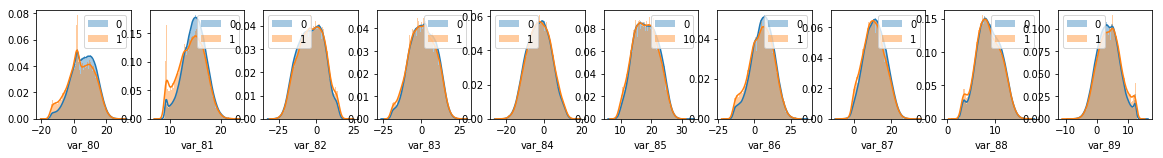

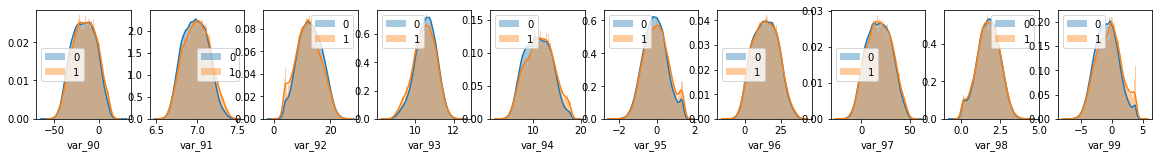

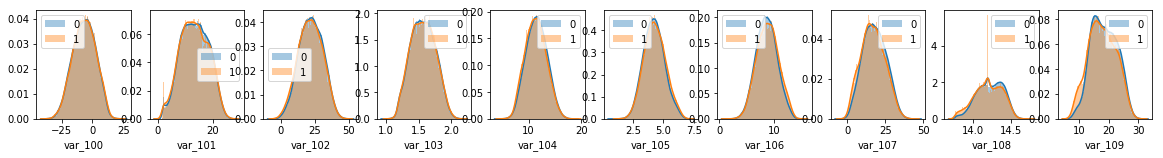

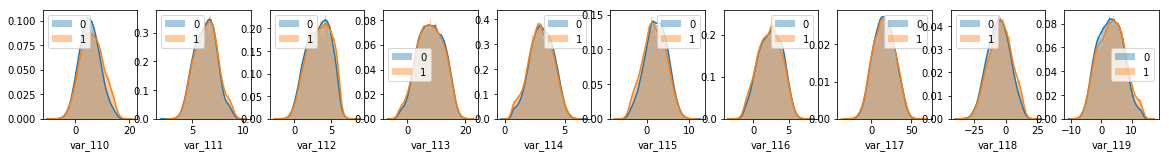

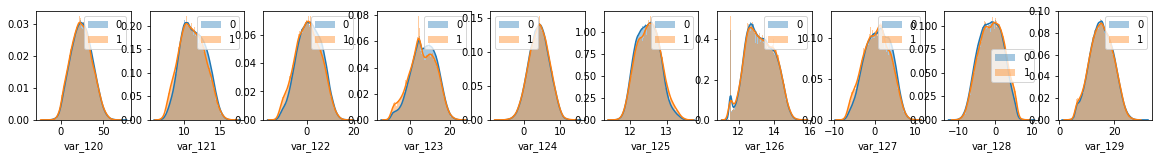

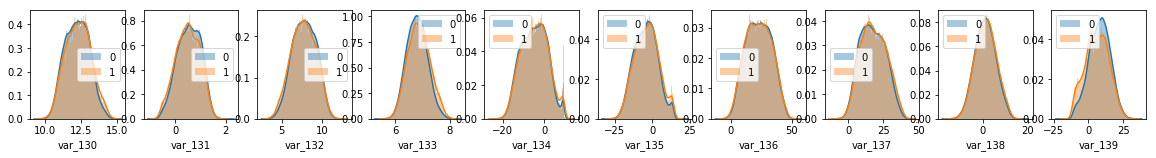

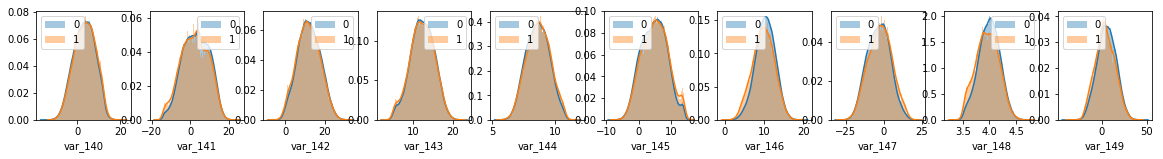

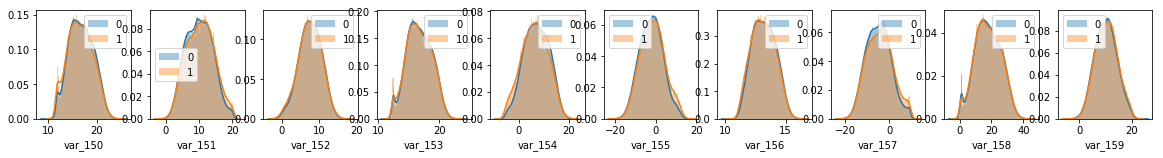

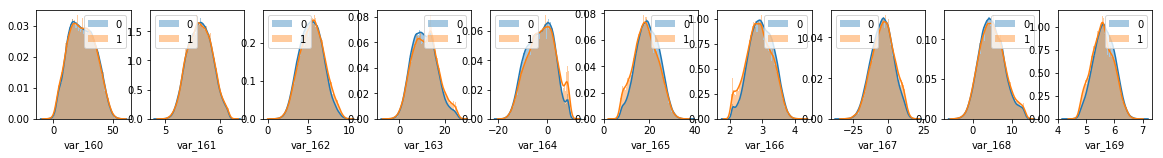

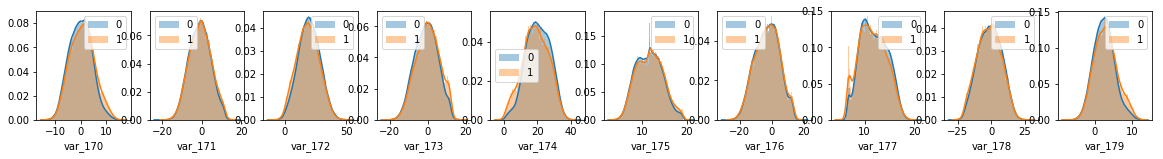

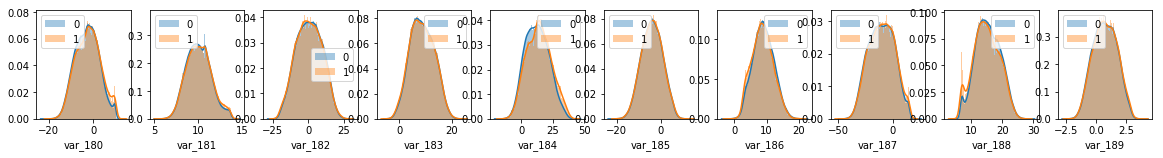

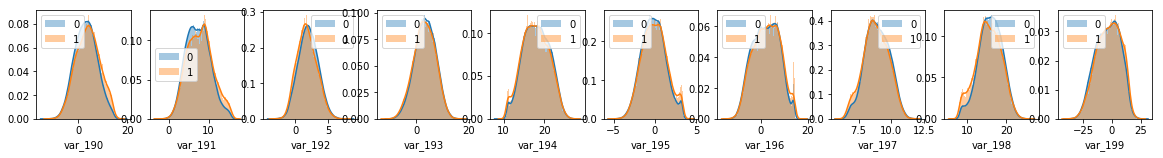

In [16]:
temp_col_list = []
train_drop = train.drop(['ID_code', 'target'], axis=1)
target_0 = train.loc[train['target'] == 0]
target_1 = train.loc[train['target'] == 1]

def draw_distplot_each_col(col, ax_n):
    sns.distplot(target_0[col], kde=True, bins=100, ax=ax_n, label='0')
    sns.distplot(target_1[col], kde=True, bins=100, ax=ax_n, label='1')
    ax_n.legend()
    
def draw_all_features(func, cols):
    for col in cols:
        temp_col_list.append(col)
        if len(temp_col_list) % 10 == 0:
            fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 2))
            for i in range(10):
                func(temp_col_list[i], axes[i])
            del temp_col_list[:]

    # Draw the rest, but there isn't in this case
    if len(temp_col_list) > 0:
        lenth_tcl = len(temp_col_list)
        fig, axes = plt.subplots(nrows=1, ncols=lenth_tcl, figsize=(lenth_tcl * 2, 2))
        for i in range(lenth_tcl):
            draw_distplot_each_col(temp_col_list[i], axes[i])

cols = meta[(meta.kind == 'continuous') & (meta.keep)].index
draw_all_features(draw_distplot_each_col, cols)

Generally, there is no skewd features and it means they are approximately normalized.

Most of the features have similar tendency for target_0 and target_1. But, some are different.
* distinctly different shape between target_0 and target_1: **var_6, var_12, var_13, var_53, var_76, var_80, var_81, var_99, var_139, var_166, var_191**
* different with normal distribution: **var_53, var_108**

***In this case, I distinguish them visually. But I think it should be distinguished by accurate number. If someone knows the method that compute differnece of distribution areas, please reply :)***

## 4-3. Boxplot
Let's check outlier of every features

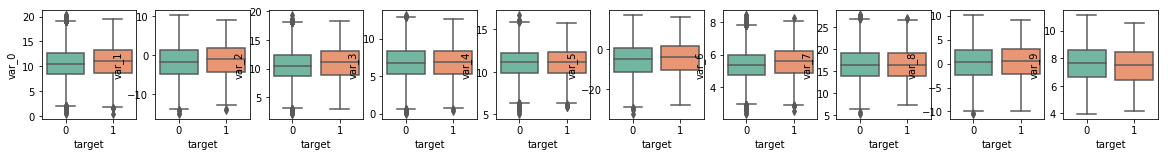

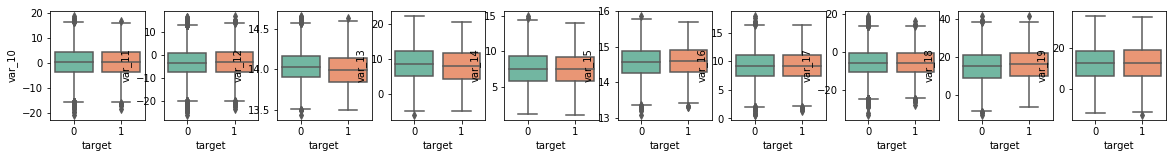

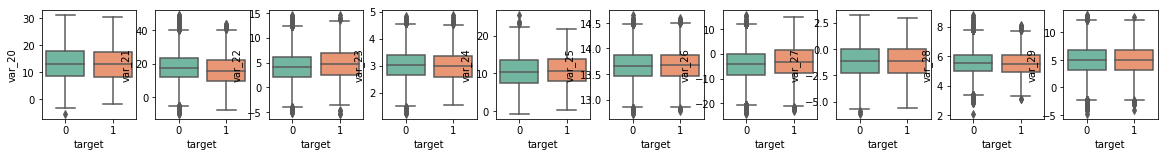

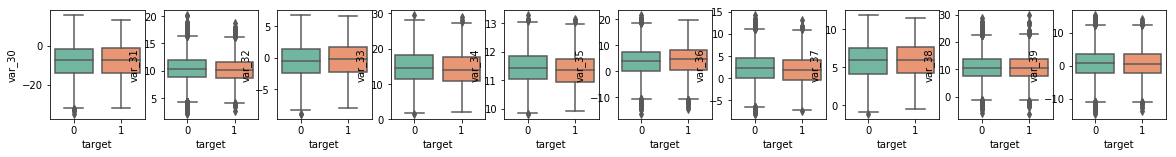

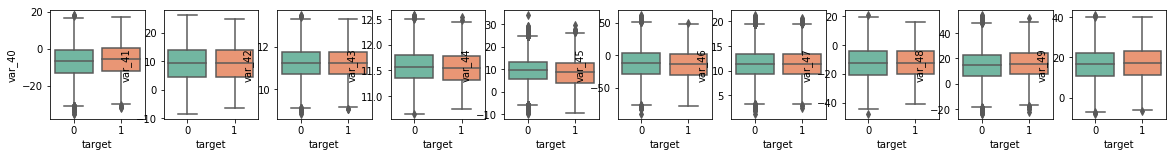

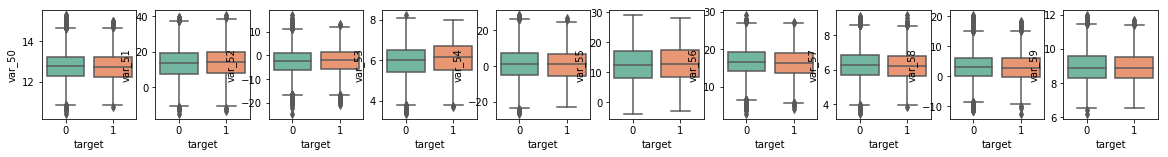

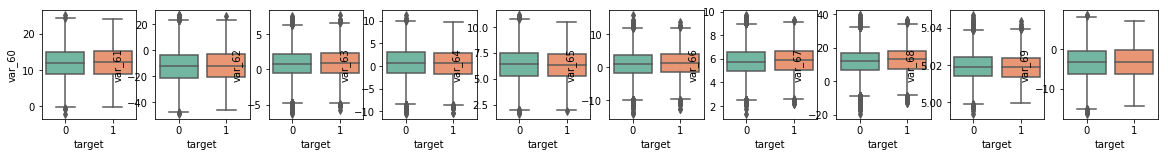

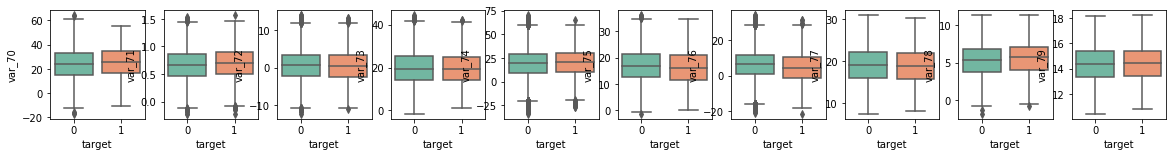

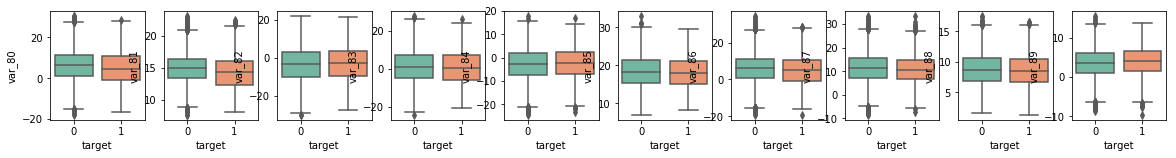

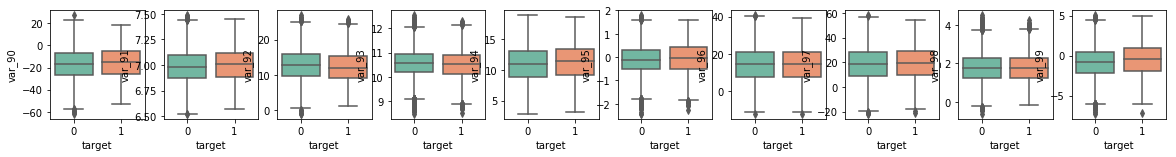

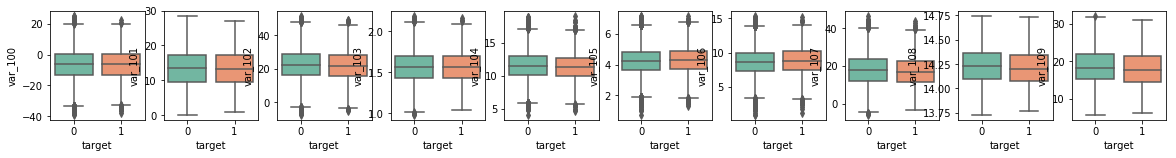

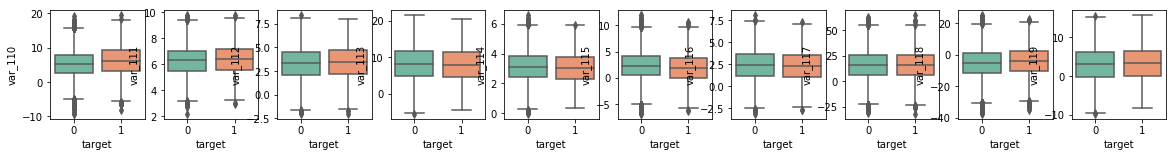

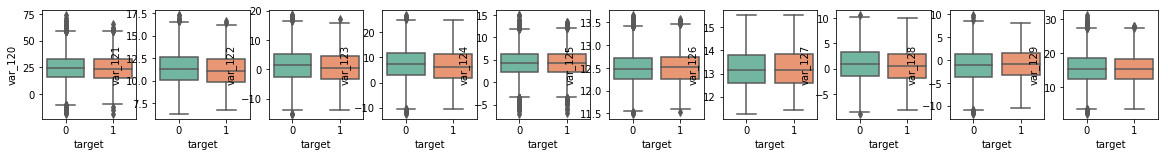

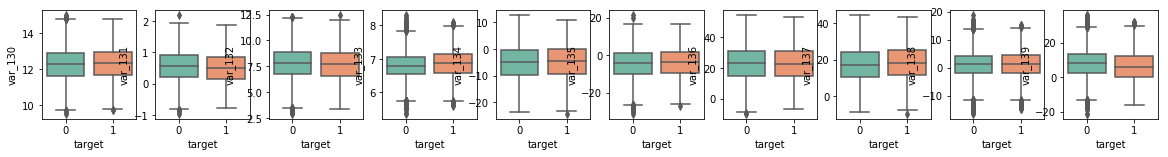

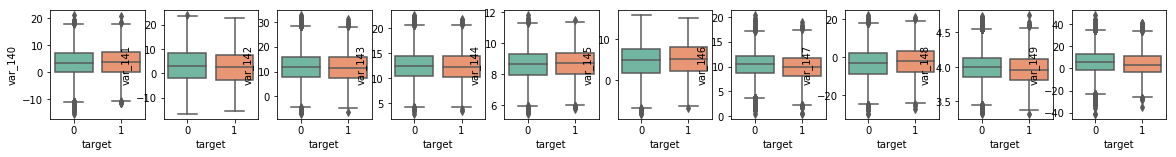

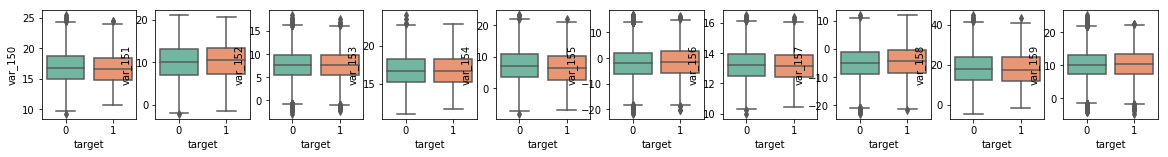

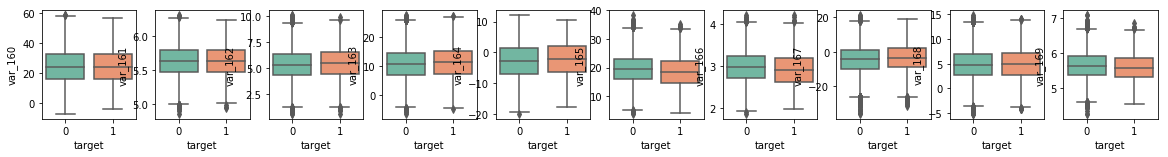

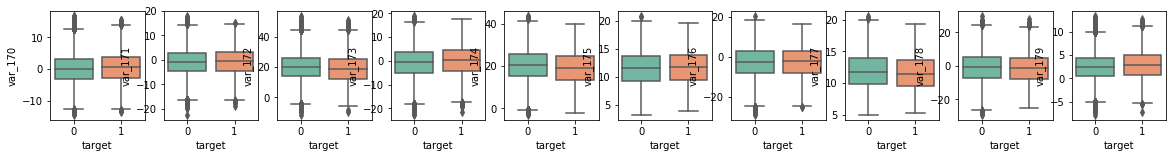

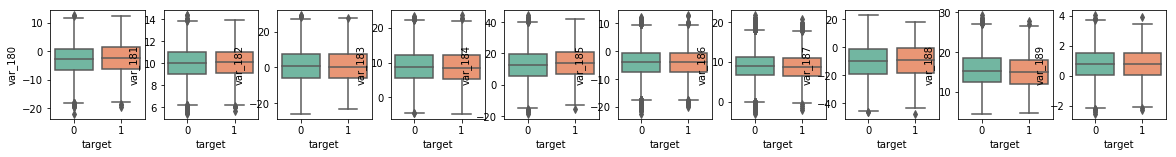

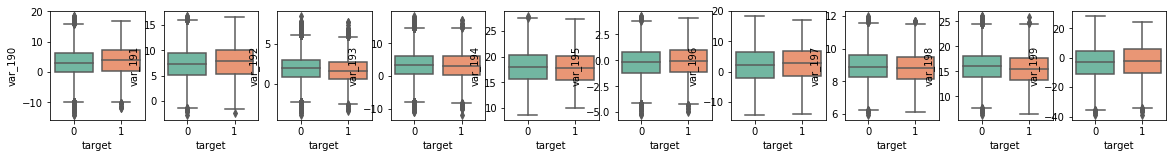

In [17]:
def draw_boxplot_each_col(col, ax_n):
    sns.boxplot(data=train, x='target', y=col, palette="Set2", ax=ax_n)
    
draw_all_features(draw_boxplot_each_col, cols)

In distribution graphs, i can see difference of distribution between target_0 and target_1 and can't figure out how many outliers in each features. But in boxplot, I can see them more clearly.
Generally, there are more outliers in target_0 than in target_1. Maybe because target_0 have more samples as 9 times than target_0 samples. For now, I don't decide wheter to remove outliers so just leave them.

## 4-4. skew

In [18]:
# object가 아닌 숫자형 피처의 컬럼 index 객체 추출
# numeric_cols = train.dtypes[train.dtypes != object].index
# int, float, object로 분류 할 수 있다

# house_df에 컬럼 index를 []로 입력하면 해당하는 컬럼 데이터 세트 반환.
skew_features = train[numerical_fs].apply(lambda x: skew(x))
# skew 정도가 1이상인 컬럼만 추출
skew_cols_top = skew_features[skew_features > 1]
print(skew_cols_top.sort_values(ascending=False))
                                 
# log변환(항상 log 변환은 아닐 수 있다)                                 
# train[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])                                 

Series([], dtype: float64)


## 4-5. heatmap

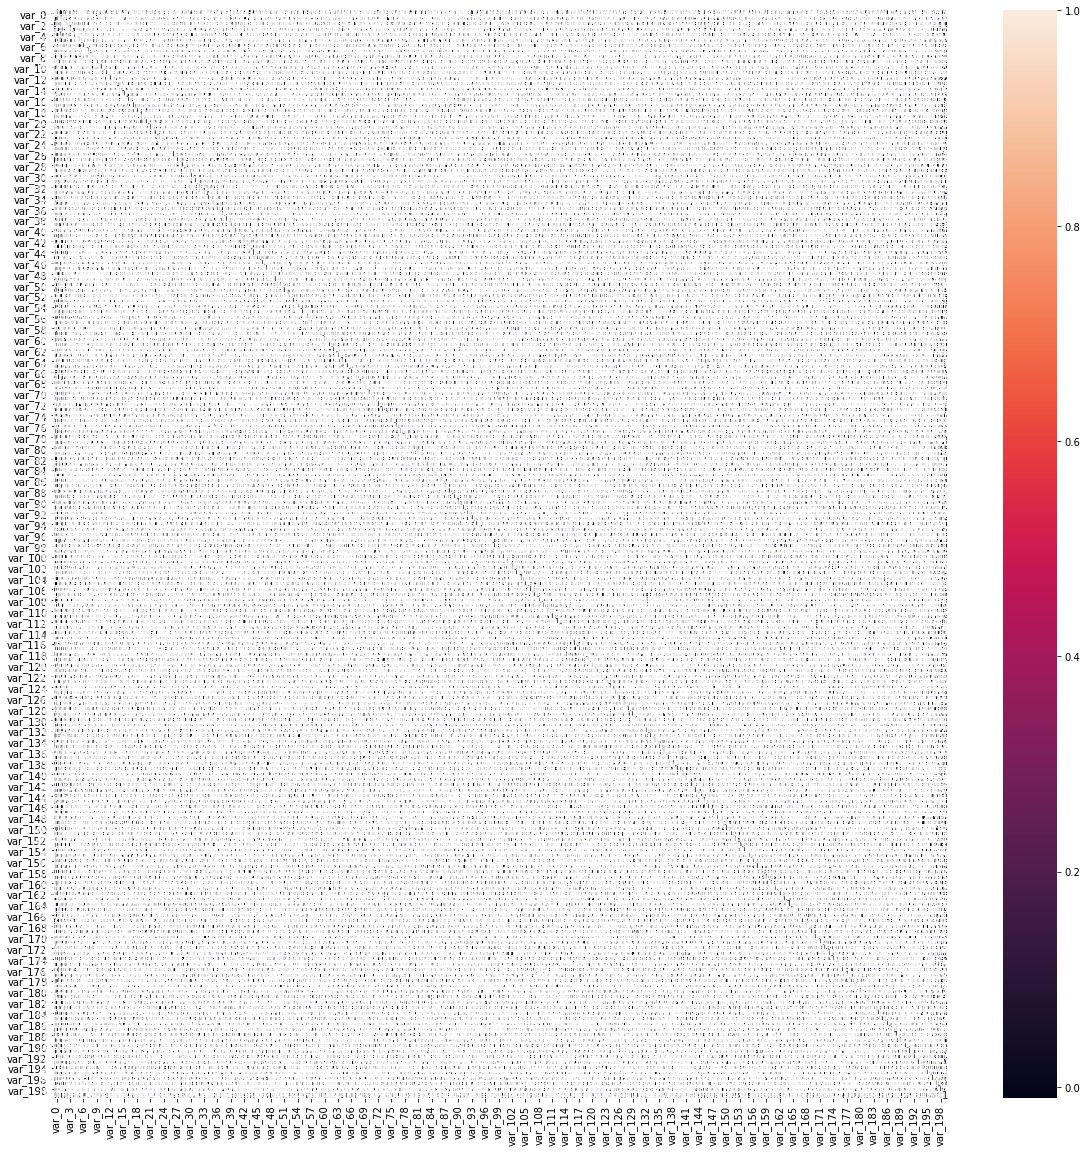

In [19]:
plt.figure(figsize=(20, 20))
sns.heatmap(train[continous_fs].corr(), annot=True)

In [20]:
# sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
# plt.show()

# ordinal Features EDA

In [21]:
for f in ordinal_fs:
    plt.figure()
    fig, ax = plt.subplots(figsize=(10, 5))
    # Calculate the percentage of target = 1 per category value
    cat_perc = train[[f, "target"]].groupby([f], as_index=False).agg(["mean", "count"])
    cat_perc = cat_perc.reset_index()
    cat_perc.sort_values(by=("target", "mean"), ascending=False, inplace=True)
    # Bar plot
    sns.barplot(ax=ax, x=f, y=("target", "mean"), data=cat_perc, order=cat_perc[f])
    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(cat_perc['target']["count"].values[i]), (p.get_x(), p.get_height() + 0.005), fontsize=14)
    plt.ylabel("% target", fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis="both", which="major", labelsize=18)
    plt.show()

heatmap. 그 결과로 아래 lmplot 진행

In [22]:
# sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
# plt.show()

# 5. Feature Engineering

I have not found any insights in EDA. And every feature is anonimyzed so I didn't hit upon any bright idea so I am going to make general features like sum, mean, std, min and max. 

## 5-1. make sum, mean, std, max, min column

In [23]:
numerical_fs
df_list = [train, test]

for df in df_list:
    # row별 각 컬럼값의 합, 최소값...을 sum이라는 컬럼에 넣음
    df['sum'] = df[numerical_fs].sum(axis=1)  
    df['min'] = df[numerical_fs].min(axis=1)
    df['max'] = df[numerical_fs].max(axis=1)
    df['mean'] = df[numerical_fs].mean(axis=1)
    df['std'] = df[numerical_fs].std(axis=1)
    df['skew'] = df[numerical_fs].skew(axis=1)
    df['kurt'] = df[numerical_fs].kurtosis(axis=1)
    df['med'] = df[numerical_fs].median(axis=1)

In [24]:
print(train.shape)
train.head()

(200000, 210)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [25]:
print(test.shape)
test.head()

(200000, 209)


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


The featrues of train and test increased by each 5(sum, mean, std, max, min).

## 5-2. PCA

In [26]:
len(train)

200000

# 6. Model Development
I am going to use lightGBM as a model.

In [27]:
features = numerical_fs + nominal_fs
target = train['target']

In [28]:
# This code, I have help from "https://www.kaggle.com/fayzur/lightgbm-customer-transaction-prediction". I added subsample = 0.9 and changed learning rate = 0.1

params = {
    'num_leaves': 18,
     'max_bin': 63,
     'min_data_in_leaf': 5,
     'learning_rate': 0.01,
     'min_sum_hessian_in_leaf': 0.0093586657313989123,
     'feature_fraction': 0.056701788569420042,
     'lambda_l1': 0.060222413158420585,
     'lambda_l2': 4.6580550589317573,
     'min_gain_to_split': 0.29588543202055562,
     'max_depth': 49,
     'save_binary': True,
     'seed': 11,
     'feature_fraction_seed': 11,
     'bagging_seed': 11,
     'drop_seed': 11,
     'data_random_seed': 11,
     'objective': 'binary',
     'boosting_type': 'gbdt',
     'verbose': 1,
     'subsample':0.9,
     'metric': 'auc',
     'is_unbalance': True,
     'boost_from_average': False
}

## 6-1. cross validtaion

## lgbm python API

In [29]:
# This code, I have help from this "https://www.kaggle.com/bertcarremans/data-preparation-exploration"
# cross_val_score와 다른 부분은 여기서는 fold별로 best_itreation 찾아서 test 예측하고 그 fold수만큼 나눠준 다는 것이다.
# 그 부분이 predictions += 이 부분

folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=11)
feature_importance_df = pd.DataFrame()
oof = np.zeros(len(train))
predictions = np.zeros(len(test))

# for x in range(10):
#     oof = np.zeros(len(train))
#     predictions = np.zeros(len(test))
    
#     params['seed'] = x

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.loc[trn_idx][features], label=target.loc[trn_idx])
    val_data = lgb.Dataset(train.loc[val_idx][features], label=target.loc[val_idx])

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.loc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.906542	valid_1's auc: 0.88146
[2000]	training's auc: 0.918221	valid_1's auc: 0.887107
[3000]	training's auc: 0.927795	valid_1's auc: 0.890937
[4000]	training's auc: 0.935536	valid_1's auc: 0.893452
[5000]	training's auc: 0.94205	valid_1's auc: 0.894921
[6000]	training's auc: 0.947888	valid_1's auc: 0.895839
[7000]	training's auc: 0.953175	valid_1's auc: 0.896454
[8000]	training's auc: 0.957949	valid_1's auc: 0.896655
[9000]	training's auc: 0.962351	valid_1's auc: 0.89677
[10000]	training's auc: 0.966337	valid_1's auc: 0.896773
Did not meet early stopping. Best iteration is:
[10000]	training's auc: 0.966337	valid_1's auc: 0.896773
fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.906306	valid_1's auc: 0.882792
[2000]	training's auc: 0.917847	valid_1's auc: 0.888671
[3000]	training's auc: 0.927476	valid_1's auc: 0.892421
[4000]	training's auc: 0.93

## lgbm sklearn API

In [30]:
# This code, I have help from this "https://www.kaggle.com/bertcarremans/data-preparation-exploration"

folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=11)
feature_importance_df = pd.DataFrame()
# oof = np.zeros(len(train))
# predictions = np.zeros(len(test))

# for x in range(10):
#     oof = np.zeros(len(train))
#     predictions = np.zeros(len(test))
    
#     params['seed'] = x

X_train = train[features]
y_train = train['target']
oof = np.zeros(len(train))
predictions = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(train.loc[trn_idx][features], label=target.loc[trn_idx])
#     val_data = lgb.Dataset(train.loc[val_idx][features], label=target.loc[val_idx])
    X_trn = X_train.loc[trn_idx]
    y_trn = y_train.loc[trn_idx]
    X_val = X_train.loc[val_idx]
    y_val = y_train.loc[val_idx]

#     num_round = 10000
#     clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
#     oof[val_idx] = clf.predict(train.loc[val_idx][features], num_iteration=clf.best_iteration)

    
    lgbm = lgb.LGBMClassifier(n_estimators=10000, random_state=11)
    lgbm.fit(X_trn, y_trn, early_stopping_rounds=3000, eval_metric='auc', eval_set=[(X_val, y_val)], verbose=1000)
    oof[val_idx] = lgbm.predict(X_val, num_iteration=lgbm.best_iteration_)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgbm.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

#     predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    predictions += lgbm.predict(test[features], num_iteration=lgbm.best_iteration_) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(y_train, oof)))

fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887526	valid_0's binary_logloss: 0.21375
[2000]	valid_0's auc: 0.885792	valid_0's binary_logloss: 0.226906
[3000]	valid_0's auc: 0.885086	valid_0's binary_logloss: 0.246932
Early stopping, best iteration is:
[562]	valid_0's auc: 0.888605	valid_0's binary_logloss: 0.210833
fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887197	valid_0's binary_logloss: 0.214982
[2000]	valid_0's auc: 0.885251	valid_0's binary_logloss: 0.227744
[3000]	valid_0's auc: 0.88499	valid_0's binary_logloss: 0.247262
Early stopping, best iteration is:
[450]	valid_0's auc: 0.88887	valid_0's binary_logloss: 0.212778
fold 2
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882178	valid_0's binary_logloss: 0.2187
[2000]	valid_0's auc: 0.882181	valid_0's binary_logloss: 0.231039
[3000]	valid_0's auc: 0.881198	valid_0's binary_logloss: 0.25223

In [31]:
y_train

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        1
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        1
         ..
199970    0
199971    0
199972    0
199973    0
199974    0
199975    0
199976    1
199977    0
199978    0
199979    0
199980    0
199981    1
199982    0
199983    0
199984    0
199985    0
199986    1
199987    0
199988    0
199989    0
199990    1
199991    0
199992    0
199993    0
199994    0
199995    0
199996    0
199997    0
199998    0
199999    0
Name: target, Length: 200000, dtype: int64

# xgboost

## xgb python API

In [32]:
params = {'eta': 0.02,
          'max_depth': 4,
          'subsample': 0.9,
          'colsample_bytree': 0.9, 
          'objective': 'binary:logistic',
          'eval_metric': 'auc',
          'silent': True}

In [33]:
####
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=11)
feature_importance_df = pd.DataFrame()
oof = np.zeros(len(train))
predictions = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.loc[trn_idx][features], label=target.loc[trn_idx])
    val_data = lgb.Dataset(train.loc[val_idx][features], label=target.loc[val_idx])

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.loc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
####

X = train.drop(['id', 'target'], axis=1)
features = X.columns
X = X.values
y = train['target'].values
sub=test['id'].to_frame()
sub['target']=0

nrounds=200  # need to change to 2000
kfold = 2  # need to change to 5
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=11f)

for fold_, (trn_index, val_index) in enumerate(folds.split(train.values, target.values)):
    print(' xgb kfold: {}  of  {} : '.format(fold_, kfold))
    X_train, X_valid = X[trn_index], X[val_index]
    y_train, y_valid = y[trn_index], y[val_index]
    d_train = xgb.DMatrix(X_train, y_train) 
    d_valid = xgb.DMatrix(X_valid, y_valid) 
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=100, 
                          feval=gini_xgb, maximize=True, verbose_eval=100)
    sub['target'] += xgb_model.predict(xgb.DMatrix(test[features].values), 
                        ntree_limit=xgb_model.best_ntree_limit+50) / (2*kfold)

SyntaxError: invalid syntax (<ipython-input-33-cbc080a012b1>, line 34)

## xgb sklearn API

## 6-2. Feature importance

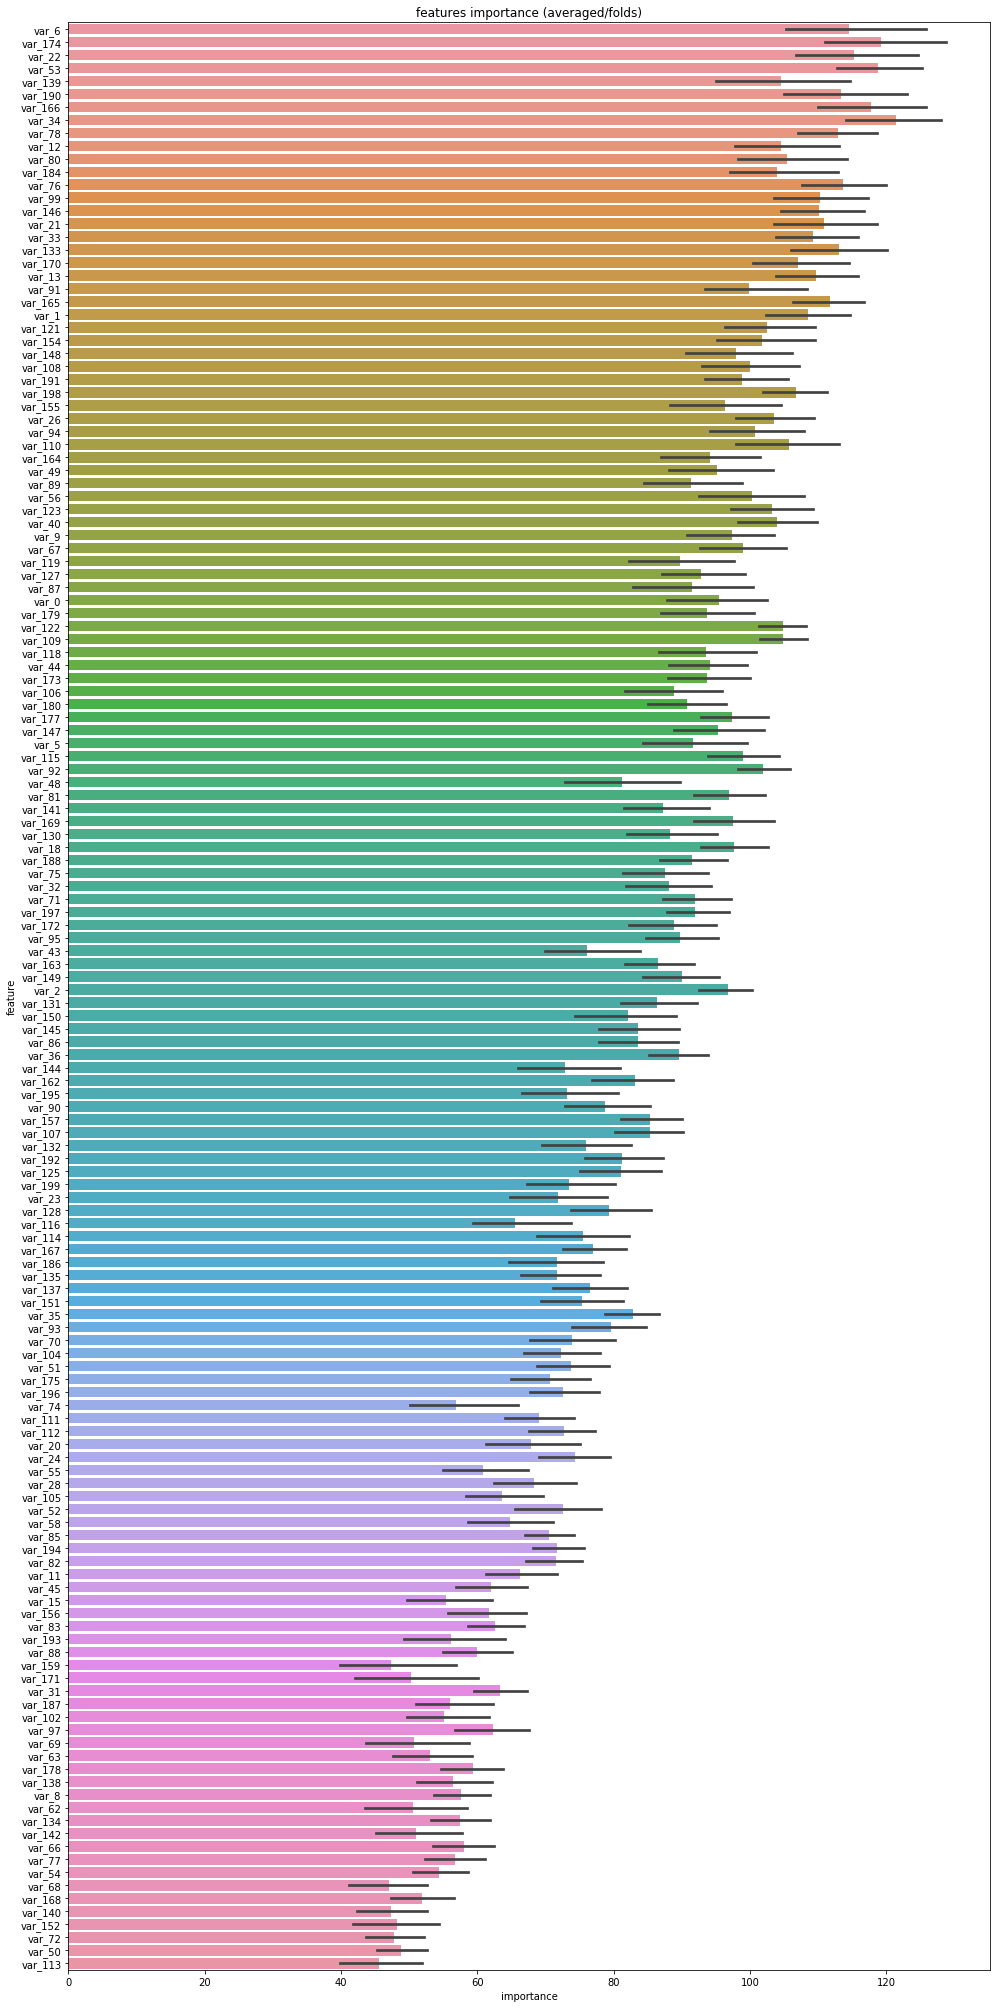

In [34]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

Top 10 important features are var_108, var_13, var_22, var_184, var_76, var_177, var_165, var_174, var_146, var_34. The features var_13 and var_76 are founded in the EDA process case1, and the feature var_108 is founded in the EDA precces case2.

## 6-3. Submit

In [35]:
submission = pd.read_csv("../input/sample_submission.csv")
submission["target"] = predictions
submission.to_csv("lgbm1.csv", index=False)

In [36]:
submission.head()

,ID_code,target
0,test_0,0.0
1,test_1,0.0
2,test_2,0.0
3,test_3,0.0
4,test_4,0.0
